In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
os.chdir("C:/Users/levi0/Downloads")

In [3]:
df = pd.read_csv("Preprocessed.csv")

In [4]:
df.head(3)

,Close,publish_date,polarity
0,4060.020020,2001-01-03,0.0000
1,4115.370117,2001-01-04,0.4767
2,4183.729980,2001-01-05,0.0000


In [5]:
df['Close'] = df.Close.diff(365).dropna()

In [6]:
df['publish_date'] = pd.to_datetime(df['publish_date']) 
df["day_of_week"] = df['publish_date'].dt.weekday
df["week_of_year"] = df['publish_date'].dt.week
df["month"] = df['publish_date'].dt.month
df['quarter'] = df['publish_date'].dt.quarter

In [7]:
df['percent_change'] = df.Close.pct_change().fillna(0)

In [8]:
group = df.groupby(['quarter']).agg({'percent_change': ['mean']})
group.columns = ['pct_quarter']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['quarter'], how='left')

In [9]:
group = df.groupby(['week_of_year']).agg({'percent_change': ['mean']})
group.columns = ['pct_week_of_year']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['week_of_year'], how='left')

In [10]:
group = df.groupby(['month']).agg({'percent_change': ['mean']})
group.columns = ['pct_month']
group.reset_index(inplace=True)

df = pd.merge(df, group, on=['month'], how='left')

In [11]:
df['polarity_shift_2'] = df.polarity.shift(2)
df['polarity_shift_3'] = df.polarity.shift(3)
df['polarity_shift_4'] = df.polarity.shift(4)

df['pol_s2_rw3'] = df.polarity_shift_2.rolling(3).mean()
df['pol_s2_rw7'] = df.polarity_shift_2.rolling(7).mean()
df['pol_s2_rw14'] = df.polarity_shift_2.rolling(14).mean()

df['pol_s3_rw3'] = df.polarity_shift_3.rolling(3).mean()
df['pol_s3_rw7'] = df.polarity_shift_3.rolling(7).mean()
df['pol_s3_rw14'] = df.polarity_shift_3.rolling(14).mean()

df['pol_s4_rw3'] = df.polarity_shift_4.rolling(3).mean()
df['pol_s4_rw7'] = df.polarity_shift_4.rolling(7).mean()
df['pol_s4_rw14'] = df.polarity_shift_4.rolling(14).mean()

In [12]:
df['lag1_Close'] = df.Close.shift(-1)

df['lag_close_rw3'] = df.lag1_Close.rolling(3).mean()
df['lag_close_rw7'] = df.lag1_Close.rolling(7).mean()
df['lag_close_rw30'] = df.lag1_Close.rolling(30).mean()
df['lag_close_rw120'] = df.lag1_Close.rolling(120).mean()

df['lag_close_ew'] = df.lag1_Close.expanding().mean()

df['lag_close_diff'] = df.lag1_Close.diff()

In [13]:
df = df.set_index("publish_date")

In [14]:
df.dropna(inplace = True)

In [15]:
X = df.drop(columns=['Close'])
y = df['Close']

In [16]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

In [17]:
from xgboost import XGBRegressor
regressor_XGB = XGBRegressor()

In [18]:
regressor_XGB.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

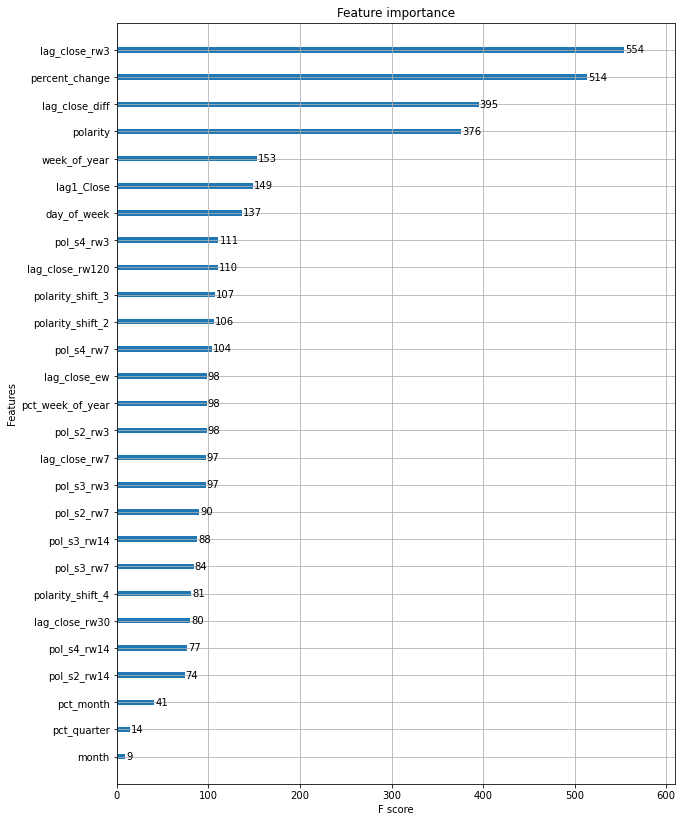

In [19]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)


plot_features(regressor_XGB, (10,14))

In [20]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge
model = Ridge()
rfe = RFE(estimator = model, n_features_to_select=15)
rfe.fit(X_scaled,y)

RFE(estimator=Ridge(), n_features_to_select=15)

In [21]:
names = X.columns.values
for i in range(len(rfe.support_)):
    if rfe.support_[i]:
        print(names[i])

week_of_year
percent_change
polarity_shift_3
polarity_shift_4
pol_s2_rw7
pol_s2_rw14
pol_s3_rw3
pol_s3_rw14
pol_s4_rw3
pol_s4_rw14
lag1_Close
lag_close_rw3
lag_close_rw7
lag_close_rw30
lag_close_diff
